## Diffraction Simulation using diffractsim

By      : Irfan Imaduddin <br>
Date    : 12 January 2022 <br>
Ref     : github.com/rafael-fuente/diffractsim <br>
Version : 2.0 <br>
Contact : irfanimaduddin@gmail.com <br>

---

# Install package

In [ ]:
!pip install diffractsim

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=05a2b72db1f2ddd5c4a619a8fdd65f8cf47ca027d35034ddf43beb666002c9f3
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


# Import necessary packages and set backend.

Note:
* CPU = CPU
* CUDA = GPU (recommended!)

In [ ]:
import diffractsim
import numpy as np

diffractsim.set_backend("CUDA") #Change the string to "CUDA" to use GPU acceleration

In [ ]:
from diffractsim import MonochromaticField, ApertureFromImage, CircularAperture, Lens, W, m, cm, mm, um, nm, bd

from diffractsim.colour_functions import ColourSystem as cs
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

plt.style.use("dark_background")

# Optical layout 

<img src="https://raw.githubusercontent.com/irfanimaduddin/doublestar_grating_diffraction/main/layout.png" height="500px"/>

Define some variables

In [ ]:
F_VIS = 1078*cm
F_PHO = 1072*cm

D_TEL = 600*mm
R_TEL = D_TEL/2.

D_GRAT = 738*mm
R_GRAT = D_GRAT/2.

D_PUPIL = 800*mm
R_PUPIL = D_PUPIL/2.

DIST_GRAT_LENS = 20*cm
DIST_PUPIL_GRAT = 30*cm

PLOT_LIM_PUPIL = 425*mm
PLOT_LIM_GRAT = 325*mm
PLOT_LIM_LENS = 325*mm

Define the information to some variables

# Initialize light source

Concept

<img src="https://raw.githubusercontent.com/irfanimaduddin/doublestar_grating_diffraction/main/Extent_NX_NY.png" width="250px"/>

The light source is assumed as paraxial rays. 

Monochromatic light source

In [ ]:
F = MonochromaticField(
    wavelength=555 * nm, # Wavelength for monochromatic light source in nm
    extent_x=100*cm, # Width of the light source assumed as rectangular (set larger than your aperture)
    extent_y=100*cm, # Height of the light source assumed as rectangular (set larger than your aperture)
    Nx=2048, # Number of pixels or grids for an extent_x value in x axis
    Ny=2048, # Number of pixels or grids for an extent_y value in y axis
    intensity=1e-7*W/(m**2) # Intensity of the light source in W/m2 (default: 0.2)
)

# Some information about fluxes arrived above the Earth atmosphere
# Sun flux = 1380 W/m2
# Sirius flux = 10-7 W/m2

# Add circular aperture right after the light source

It's assumed as entrance pupil of the telescope

In [ ]:
F.add(CircularAperture(radius=R_PUPIL))

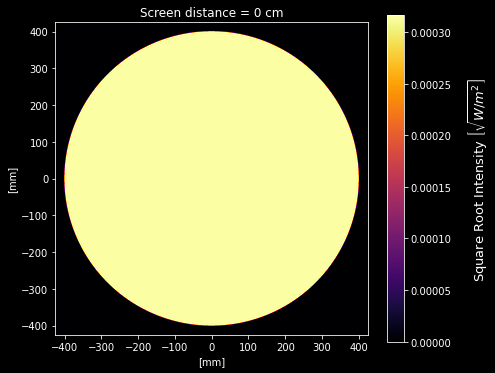

In [ ]:
F.plot_intensity(square_root=True, xlim=[-PLOT_LIM_PUPIL, PLOT_LIM_PUPIL], ylim=[-PLOT_LIM_PUPIL, PLOT_LIM_PUPIL])

# Add grating (optional)

Propagate light as long as $d_{pupil-grating}$.

In [ ]:
F.propagate(DIST_PUPIL_GRAT)

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:454: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


Add grating

In [ ]:
F.add(ApertureFromImage("bosscha_grating2021_rect.png", image_size=(D_GRAT, D_GRAT), simulation=F))

FileNotFoundError: ignored

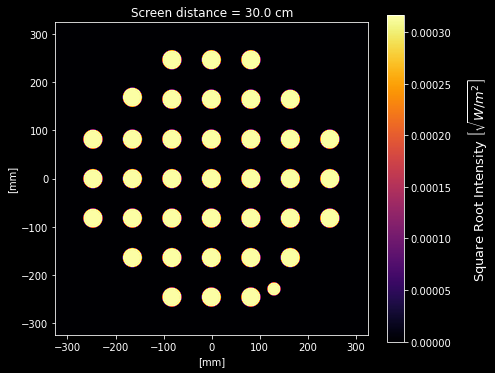

In [ ]:
F.plot_intensity(square_root=True, xlim=[-PLOT_LIM_GRAT, PLOT_LIM_GRAT], ylim=[-PLOT_LIM_GRAT, PLOT_LIM_GRAT])

# Add Thick Lens (could be more than one).

Propagate light as long as $d_{grating-lens}$.

In [ ]:
F.propagate(DIST_GRAT_LENS+DIST_PUPIL_GRAT)

Add lens where the focal length values are:
* $F_{visual} = 1078$ cm
* $F_{photography} = 1072$ cm

In [ ]:
# Uncomment one of these two lines
F.add(Lens(f=F_VIS, radius=R_TEL)) # Visual Telescope 
# F.add(Lens(f=F_PHO, radius=R_TEL)) # Photography Telescope

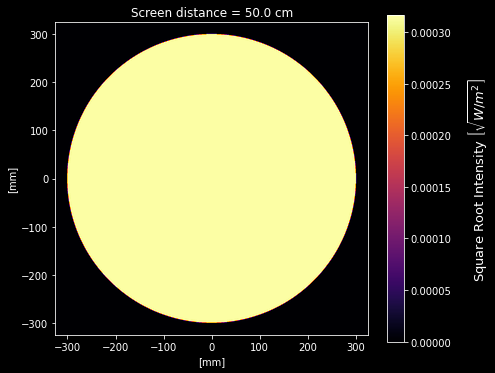

In [ ]:
F.plot_intensity(square_root=True, xlim=[-PLOT_LIM_LENS, PLOT_LIM_LENS], ylim=[-PLOT_LIM_LENS, PLOT_LIM_LENS])

# Scale Light Propagation

Rescale the simulation plane to be able to see the small PSF of the telescope (IT'S A MUST!). `scale_factor` is a free variable.


In [ ]:
# Uncomment one of these two lines
F.scale_propagate(F_VIS, scale_factor=0.0014) # Visual Telescope
# F.scale_propagate(F_PHO, scale_factor=0.0014) # Photography Telescope

# Intensity Plot of The System

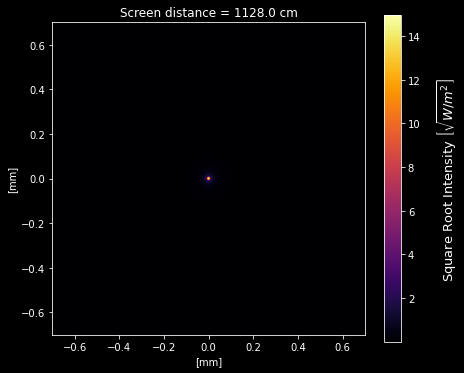

In [ ]:
F.plot_intensity(square_root=True)

# Longitudinal Profile

Get longitudinal profile of the light (quite similar with ray trace). Firstly, define distance range of longitudinal profile that we want to examine.

In [ ]:
DIST_LONG_INI = 0*cm
DIST_LONG_END = 1200*cm
STEPS = 100 # Number of steps from DIST_LONG_INI to DIST_LONG_END (like np.linspace)

In [ ]:
longitudinal_profile_rgb, longitudinal_profile_E = F.get_longitudinal_profile(start_distance=DIST_LONG_INI, end_distance=DIST_LONG_END, steps=STEPS)

Took 5.020049333572388


## Plot longitudinal profile

Set initial and final plot distances.

In [ ]:
DIST_INI = 1120*cm
DIST_END = 1140*cm

Plot longitudinal profile colors

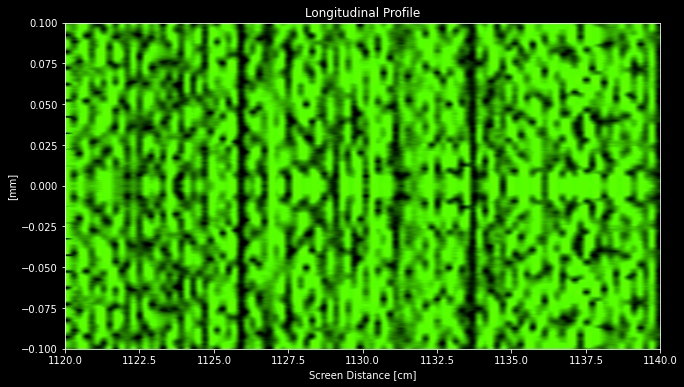

In [ ]:
F.plot_longitudinal_profile_colors(longitudinal_profile_rgb=longitudinal_profile_rgb, start_distance=DIST_INI, end_distance=DIST_END, ylim=[-0.1*mm, 0.1*mm], xlim=[DIST_INI,DIST_END])
#F.plot_longitudinal_profile_colors(longitudinal_profile_rgb=longitudinal_profile_rgb, start_distance=0*cm, end_distance=1200*cm, ylim=[-300*mm, 300*mm])

Plot longitudinal profile intensity

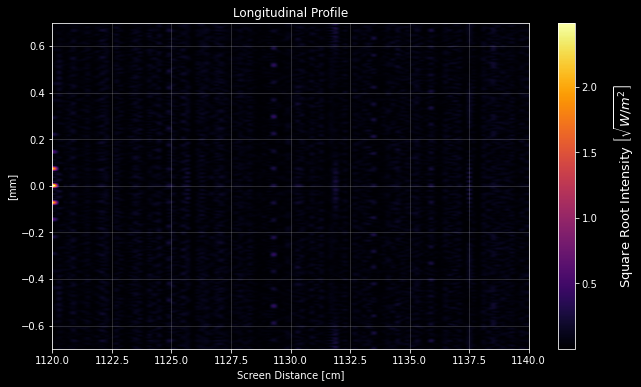

In [ ]:
F.plot_longitudinal_profile_intensity(longitudinal_profile_E, start_distance=DIST_INI, end_distance=DIST_END, square_root=True, grid=True)

Plot colors

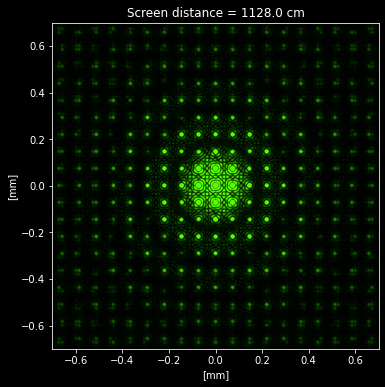

In [ ]:
rgb = F.get_colors()

F.plot_colors(rgb)

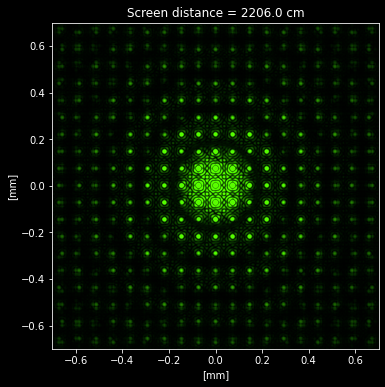

In [ ]:
F.compute_colors_at(F_VIS)
F.plot_colors(rgb)

# Playing with Focal length

Imagine that we are setting the focal length experimentally to get the best focus. We already know that we are looking for the smallest diameter of the object at this process. But actually, we're looking for the best RMS in radius $R$ axis ($R^2=x^2+y^2$).

In [ ]:
# Initialize the light source as well

F = MonochromaticField(
    wavelength=555 * nm, # Wavelength for monochromatic light source in nm
    extent_x=100*cm, # Width of the light source assumed as rectangular (set larger than your aperture)
    extent_y=100*cm, # Height of the light source assumed as rectangular (set larger than your aperture)
    Nx=4096, # Number of pixels or grids for an extent_x value in x axis
    Ny=4096, # Number of pixels or grids for an extent_y value in y axis
    intensity=1e-7*W/(m**2) # Still using Sirius flux in W/m2 (default: 0.2)
)

# Add the circular aperture
F.add(CircularAperture(radius=R_PUPIL))

# Set grating distance from the aperture
F.propagate(DIST_PUPIL_GRAT)

# Add grating
F.add(ApertureFromImage("bosscha_grating2021_rect.png", image_size=(D_GRAT, D_GRAT), simulation=F))

# Set lens distance from the grating
F.propagate(DIST_GRAT_LENS)

# Add lenses (don't forget to uncomment one of these lines)
F.add(Lens(f=F_VIS, radius=R_TEL)) # Visual Telescope

hi = 1010*cm

F.propagate(hi)

"""visualize the diffraction pattern colors with matplotlib"""
 # rgb = rgb.get()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(-.7*mm, .7*mm)
ax.set_ylim(-.7*mm, .7*mm)

# we use mm by default
ax.set_xlabel("[mm]")
ax.set_ylabel("[mm]")

Z = np.full((100), 1*cm)

im = ax.imshow([[],[]], interpolation="spline36", origin = "lower")

def init():
  #init image
  im.set_data([[],[]])
  return im #return everything that must be updated

def animate(i):
  global hi
  #animate image
  F.scale_propagate(Z[i], scale_factor=0.0014)
  im.set_data(F.get_colors().get())
  ax.set_title("Screen distance = " + str(F.z * 100) + " cm")
  hi+= Z[i]
  print("{} Done!".format(hi))
  return im, ax #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(Z), interval=10, repeat=False)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

# anim.save(os.path.join(BASE_DIR, DIRECTORY, 'fwhms_v{}_{}_{}.mp4'.format(PLATENUM, DPI, FILENUM)), fps=60)
plt.close()

10.11 Done!
10.12 Done!
10.129999999999999 Done!
10.139999999999999 Done!
10.149999999999999 Done!
10.159999999999998 Done!
10.169999999999998 Done!
10.179999999999998 Done!
10.189999999999998 Done!
10.199999999999998 Done!
10.209999999999997 Done!
10.219999999999997 Done!
10.229999999999997 Done!
10.239999999999997 Done!
10.249999999999996 Done!
10.259999999999996 Done!
10.269999999999996 Done!
10.279999999999996 Done!
10.289999999999996 Done!
10.299999999999995 Done!
10.309999999999995 Done!
10.319999999999995 Done!
10.329999999999995 Done!
10.339999999999995 Done!
10.349999999999994 Done!
10.359999999999994 Done!
10.369999999999994 Done!
10.379999999999994 Done!
10.389999999999993 Done!
10.399999999999993 Done!
10.409999999999993 Done!
10.419999999999993 Done!
10.429999999999993 Done!
10.439999999999992 Done!
10.449999999999992 Done!
10.459999999999992 Done!
10.469999999999992 Done!
10.479999999999992 Done!
10.489999999999991 Done!
10.499999999999991 Done!
10.509999999999991 Done!
1

In [ ]:
N = len(trail_data[0])

fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlim(0, len(positions[0]))
ax.set_ylim(0, 4e4)
ax.set_ylabel('Intensities')    
    
plot1 = plt.plot([], '.')[0] #lines to animate
plot2 = plt.plot([])[0] #lines to animate

# patches = plot1 + plot2 #things to animate

def init():
    #init plot1
    plot1.set_data([], [])
    #init plot2
    plot2.set_data([], [])
    return plot1, plot2 #return everything that must be updated

def animate(i):
    #set label
    label = 'Y axis for X = {}'.format(i+1)
    ax.set_xlabel(label)
    #animate plot1
    plot1.set_data(positions[i], trail_data[::,i])
    #animate plot2
    plot2.set_data(positions[i], fit_data[i])
    return plot1, plot2,ax #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=10, repeat=False)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

# anim.save(os.path.join(BASE_DIR, DIRECTORY, 'fwhms_v{}_{}_{}.mp4'.format(PLATENUM, DPI, FILENUM)), fps=60)
plt.close()

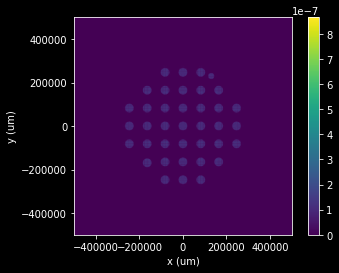

In [ ]:
# Image plot of PSF
extent = 1e6 * plt.array([F.x.get().min(), F.x.get().max(), F.y.get().min(), F.y.get().max()])
plt.imshow(F.I.get(), extent=extent)
# plt.xlim(-30, 30)
# plt.ylim(-30, 30)
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/diffractsim/__init__.py


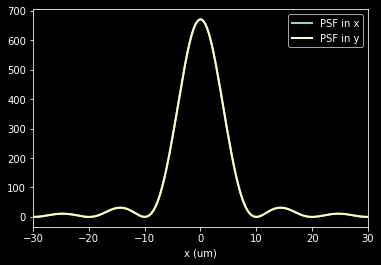

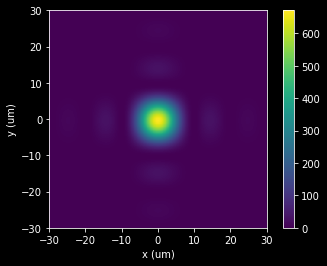

In [ ]:
import diffractsim
from diffractsim import MonochromaticField,Lens, nm
print(diffractsim.__file__)
import pylab as pl
# Change the string to "CUDA" to use GPU acceleration
diffractsim.set_backend("CPU")

# PARAMETERS
wlen = 1000 * nm
Nx = Ny = 2048
dx = dy = 400 * nm
focal_distance = 10 * Nx * dx  # 10 times lens diameter

# SETUP AND PROPAGATION
F = MonochromaticField(
    wavelength=wlen,
    extent_x=Nx * dx,
    extent_y=Nx * dx,
    Nx=Nx,
    Ny=Ny)

F.add(Lens(f=focal_distance))
F.propagate(focal_distance)

# POST PROCESSING
# Find indices closest to (0,0)
idx_x = pl.argmin(abs(F.x-0))
idx_y = pl.argmin(abs(F.y-0))
# Plot PSF cross-sectionis
pl.plot(F.x * 1e6, F.I[idx_x, :], label='PSF in x', lw=2)
pl.plot(F.y * 1e6, F.I[:, idx_y], label='PSF in y', lw=2)
pl.xlabel('x (um)')
pl.xlim(-30, 30)
pl.legend()
pl.show()

# Image plot of PSF
extent = 1e6 * pl.array([F.x.min(), F.x.max(), F.y.min(), F.y.max()])
pl.imshow(F.I, extent=extent)
pl.xlim(-30, 30)
pl.ylim(-30, 30)
pl.xlabel('x (um)')
pl.ylabel('y (um)')
pl.colorbar()
pl.show()

Took 15.527594089508057


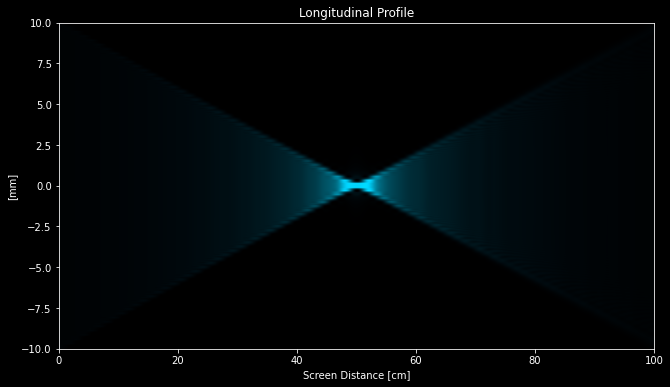

In [ ]:
import diffractsim
diffractsim.set_backend("CUDA") #Change the string to "CUDA" to use GPU acceleration
# Note: this example is highly recommendeded to run with CUDA

from diffractsim import MonochromaticField, ApertureFromImage, Lens, nm, mm, cm

F = MonochromaticField(
    wavelength=488 * nm, extent_x=20. * mm, extent_y=20. * mm, Nx=4096, Ny=4096,intensity = 0.0001
)

#F.add(ApertureFromImage("./apertures/QWT.png",  image_size =(15 * mm, 15 * mm), simulation = F))
F.add(Lens(f = 50*cm))


longitudinal_profile_rgb, longitudinal_profile_E = F.get_longitudinal_profile( start_distance = 0*cm , end_distance = 100 *cm , steps = 80) 
#plot colors
F.plot_longitudinal_profile_colors(longitudinal_profile_rgb = longitudinal_profile_rgb, start_distance = 0*cm , end_distance = 100 *cm)